In [45]:
import RandomNumberGenerator as rand
import numpy as np
import math
import time
import tqdm
import matplotlib.pyplot as plt
import copy

rand_p = rand.RandomNumberGenerator(940)
rand_w = rand.RandomNumberGenerator(98)
rand_d = rand.RandomNumberGenerator(689)
rand_0 = rand.RandomNumberGenerator(56)
rand_1 = rand.RandomNumberGenerator(3)
rand_2 = rand.RandomNumberGenerator(345)
rand_3 = rand.RandomNumberGenerator(10)
rand_4 = rand.RandomNumberGenerator(935)
rand_5 = rand.RandomNumberGenerator(90)
rand_6 = rand.RandomNumberGenerator(87)
rand_7 = rand.RandomNumberGenerator(6556)
rand_generator = [rand_0, rand_1, rand_2, rand_3, rand_4, rand_5, rand_6, rand_7]

A = 0
number_of_machines = 3
n = 30
p_periods = np.zeros((number_of_machines, n))
d_deadlies = np.zeros(n)
for i in range(number_of_machines):
    for j in range(n):
        p_periods[i,j] = rand_p.nextInt(1,99)
        A = A + p_periods[i,j]
# B = (1/2)*A
# A = (1/6)*A
# B = (1/12)*A
# A = (1/24)*A
B = int(np.floor((1/2) * A))
A = int(np.floor((1/6) * A))
for j in range(n):
    d_deadlies[j] = rand_d.nextInt(A, B)

In [46]:
def goal_function(permutation, periods, deadlines, number_machines, criterion = 1):
    n = len(permutation)
    C = np.zeros((number_machines, n))
    for i in range(number_machines):
        for j in range(n):
            #C[i,j] = max(C[i-1,j], C[i,j-1]) + periods[i, j]
            if j > 1 and i > 1:
                C[i][permutation[j]] = np.maximum(C[i - 1][permutation[j]], C[i][permutation[j - 1]]) + periods[i][permutation[j]]  # (1)
            if j == 1 and i > 1:
                C[i][permutation[j]] = C[i - 1][permutation[j]] + periods[i][permutation[j]]  # (2)
            if j > 1 and i == 1:
                C[i][permutation[j]] = C[i][permutation[j - 1]] + periods[i][permutation[j]]  # (3)
            if j == 1 and i == 1:
                C[i][permutation[j]] = periods[i][permutation[j]]  # (4)
    # Czas zakończenia wszystkich zadań (makespan)
    if(criterion == 1):
        try:
            return max(C[2, :])
        except:
            print(periods)
    
    # Maksymalne spóźnienie zadania (max tardiness)
    if(criterion == 2):
        return max(max(C[2,:]-deadlines[:]),0)
    
    # Maksymalna nieterminowość zadania (max lateness)
    if(criterion == 3):
        return max(C[2,:]-deadlines[:])
    
    # Suma nieterminowości zadań (total lateness)
    if(criterion == 4):
        total = 0
        for i in range(len(deadlines)):
            total = total + max(C[2,i]-deadlines[i], 0)
        return total

In [47]:
def get_random_permutation(n, random_gen):
    available = [x for x in range(n)]
    result = []
    for i in range(n):
        index = random_gen.nextInt(0, len(available)-1)
        result.append(available.pop(index))
    return result

In [48]:
def roll(n, random_gen):
    random_gen.nextInt(1, n)
    result = []
    result.append(random_gen.nextInt(0, n-1))
    result.append(random_gen.nextInt(0, n-1))
    while result[0] == result[1]:
        result[1] = random_gen.nextInt(0,n-1)
    return result

roll(5, rand_w)

[4, 0]

In [49]:
def task_1(periods, deadlines, number_machines, max_iter, random_gen, proba = 0.05):
    n = len(deadlines)
    P = []
    x = get_random_permutation(n, random_gen[0])
    P.append(copy.deepcopy(x))
#     print(f'Poczatkowe: {P}')
    for it in range(max_iter):
#         if(P[0] == []):
#             print(f'Index: {it}')
        numbers_to_change = roll(n, random_gen[1])
        x_prim = copy.deepcopy(x)
        x_prim[numbers_to_change[0]] = x[numbers_to_change[1]]
        x_prim[numbers_to_change[1]] = x[numbers_to_change[0]]
        
        x_goal_f_1 = goal_function(x, periods, deadlines, number_machines, 1)
        x_goal_f_2 = goal_function(x, periods, deadlines, number_machines, 2)
        x_prim_goal_f_1 = goal_function(x_prim, periods, deadlines, number_machines, 1)
        x_prim_goal_f_2 = goal_function(x_prim, periods, deadlines, number_machines, 2)
        if((x_prim_goal_f_1 < x_goal_f_1 and x_prim_goal_f_2 <= x_goal_f_2) or (x_prim_goal_f_1 <= x_goal_f_1 and x_prim_goal_f_2 < x_goal_f_2)):
            x = copy.deepcopy(x_prim)
            P.append(copy.deepcopy(x_prim))
        else:
            if(proba > random_gen[2].nextFloat(0,1)):
                #x.clear() #Tutaj był błąd, nie wiedzieć czemu przypisanie z linijki niżej nie działało
                x = copy.deepcopy(x_prim)
                P.append(copy.deepcopy(x_prim))
#     print(f'Późniejsze: {P}')
    F = copy.deepcopy(P)
#     print(f'P: {P}')
#     print(f'F: {F}')
    for i in range(len(P)):
        b_1 = goal_function(P[i], periods, deadlines, number_machines, 1)
        b_2 = goal_function(P[i], periods, deadlines, number_machines, 2)
        for a in F:
            a_1 = goal_function(a, periods, deadlines, number_machines, 1)
            a_2 = goal_function(a, periods, deadlines, number_machines, 2)
            if((a_1 < b_1 and a_2 <= b_2) or (a_1 <= b_1 and a_2 < b_2)):
                F.remove(P[i])
                break
    P_f_goal_1 = []
    P_f_goal_2 = []
    F_f_goal_1 = []
    F_f_goal_2 = []
    for i in range(len(P)):
        P_f_goal_1.append(goal_function(P[i], periods, deadlines, number_machines, 1))
        P_f_goal_2.append(goal_function(P[i], periods, deadlines, number_machines, 2))
    for i in range(len(F)):
        F_f_goal_1.append(goal_function(F[i], periods, deadlines, number_machines, 1))
        F_f_goal_2.append(goal_function(F[i], periods, deadlines, number_machines, 2))
    return P, F, P_f_goal_1, P_f_goal_2, F_f_goal_1, F_f_goal_2           

In [50]:
P, F, P_goal_1, P_goal_2, F_goal_1, F_goal_2 = task_1(p_periods, d_deadlies, number_of_machines, 1000, rand_generator)

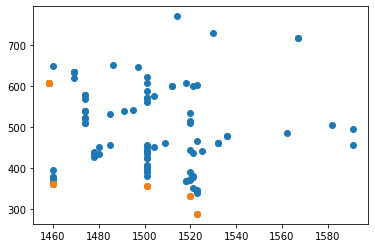

In [51]:
def plot_pareto(F_goal_1, F_goal_2, P_goal_1, P_goal_2):
    plt.scatter(P_goal_1, P_goal_2)
    plt.scatter(F_goal_1, F_goal_2)
    plt.show()

plot_pareto(F_goal_1, F_goal_2, P_goal_1, P_goal_2)

## Zadanie 2

In [52]:
def task_2(periods, deadlines, number_machines, max_iter, random_gen, factors, proba = 0.05):
    n = len(deadlines)
    x = get_random_permutation(n, random_gen[0])
    x_best = copy.deepcopy(x)
    for i in range(max_iter):
        n = len(deadlines)
        numbers_to_change = roll(n, random_gen[1])
        x_prim = copy.deepcopy(x)
        x_prim[numbers_to_change[0]] = x[numbers_to_change[1]]
        x_prim[numbers_to_change[1]] = x[numbers_to_change[0]]
        
        goal_function_x = 0
        goal_function_x_prim = 0
        goal_function_x_best = 0
        for j in range(3):
            goal_function_x = goal_function_x + (goal_function(x, periods, deadlines, number_machines, j+1)*factors[j])
            goal_function_x_prim = goal_function_x_prim + (goal_function(x_prim, periods, deadlines, number_machines, j+1)*factors[j])
            goal_function_x_best = goal_function_x_best + (goal_function(x_best, periods, deadlines, number_machines, j+1)*factors[j])                                     
#             print(f'{j}: {goal_function(x_prim, periods, deadlines, number_machines, j+1)*factors[j]}')
#         print('----------')
        if goal_function_x_prim < goal_function_x:
            x = copy.deepcopy(x_prim)
            if goal_function_x < goal_function_x_best:
                x_best = copy.deepcopy(x)
        else:
            if proba > random_gen[2].nextFloat(0,1):
                x = copy.deepcopy(x_prim)
        #print(goal_function_x)
    goal_function_best = 0
    return goal_function_x_best
                    

In [53]:
task_2(p_periods, d_deadlies, number_of_machines, 1000, rand_generator, [1, 2.65, 2.65])

2268.4

In [35]:
def task_3(periods, deadlines, number_machines, max_iter, random_gen, proba = 0.05):
    n = len(deadlines)
    P = []
    x = get_random_permutation(n, random_gen[0])
    P.append(copy.deepcopy(x))
#     print(f'Poczatkowe: {P}')
    for it in range(max_iter):
#         if(P[0] == []):
#             print(f'Index: {it}')
        numbers_to_change = roll(n, random_gen[1])
        x_prim = copy.deepcopy(x)
        x_prim[numbers_to_change[0]] = x[numbers_to_change[1]]
        x_prim[numbers_to_change[1]] = x[numbers_to_change[0]]
        
        x_goal_f = []
        x_prim_goal_f = []
        for j in range(4):
            x_goal_f.append(goal_function(x, periods, deadlines, number_machines, j+1))
            x_prim_goal_f.append(goal_function(x_prim, periods, deadlines, number_machines, j+1))
        is_better = False
        for j in range(4):
            if x_prim_goal_f[3-j] < x_goal_f[3-j] and x_prim_goal_f[2-j] <= x_goal_f[2-j] and x_prim_goal_f[1-j] <= x_goal_f[1-j] and x_prim_goal_f[0-j] <= x_goal_f[0-j]:
                x = copy.deepcopy(x_prim)
                P.append(copy.deepcopy(x_prim))
                is_better = True
                break
        if is_better == False:
            if(proba > random_gen[2].nextFloat(0,1)):
                #x.clear() #Tutaj był błąd, nie wiedzieć czemu przypisanie z linijki niżej nie działało
                x = copy.deepcopy(x_prim)
                P.append(copy.deepcopy(x_prim))
#     print(f'Późniejsze: {P}')
    F = copy.deepcopy(P)
#     print(f'P: {P}')
#     print(f'F: {F}')
    for i in range(len(P)):
        b_goal_f = []
        for j in range(4):
            b_goal_f.append(goal_function(P[i], periods, deadlines, number_machines, j+1))
        for a in F:
            a_goal_f = []
            for j in range(4):
                a_goal_f.append(goal_function(a, periods, deadlines, number_machines, j+1))
            to_remove = False
            for j in range(4):
                if a_goal_f[3-j] < b_goal_f[3-j] and a_goal_f[2-j] <= b_goal_f[2-j] and a_goal_f[1-j] <= b_goal_f[1-j] and a_goal_f[0-j] <= b_goal_f[0-j]:
                   to_remove = True
                   break
            if to_remove == True:
                F.remove(P[i])
                break
    P_f_goal_1 = []
    P_f_goal_2 = []
    P_f_goal_3 = []
    P_f_goal_4 = []
                   
    F_f_goal_1 = []
    F_f_goal_2 = []
    F_f_goal_3 = []
    F_f_goal_4 = []
    for i in range(len(P)):
        P_f_goal_1.append(goal_function(P[i], periods, deadlines, number_machines, 1))
        P_f_goal_2.append(goal_function(P[i], periods, deadlines, number_machines, 2))
        P_f_goal_3.append(goal_function(P[i], periods, deadlines, number_machines, 3))
        P_f_goal_4.append(goal_function(P[i], periods, deadlines, number_machines, 4))
    for i in range(len(F)):
        F_f_goal_1.append(goal_function(F[i], periods, deadlines, number_machines, 1))
        F_f_goal_2.append(goal_function(F[i], periods, deadlines, number_machines, 2))
        F_f_goal_3.append(goal_function(F[i], periods, deadlines, number_machines, 3))
        F_f_goal_4.append(goal_function(F[i], periods, deadlines, number_machines, 4))
    return P, F, P_f_goal_1, P_f_goal_2, P_f_goal_3, P_f_goal_4, F_f_goal_1, F_f_goal_2, F_f_goal_3, F_f_goal_4           

In [36]:
P, F, P_goal_1, P_goal_2, P_goal_3, P_goal_4, F_goal_1, F_goal_2, F_goal_3, F_goal_4 = task_3(p_periods, d_deadlies, number_of_machines, 10000, rand_generator, 0.05)

In [37]:
print('Kryt 1:')
print(P_goal_1)
print('Kryt 2:')
print(P_goal_2)
print('Kryt 3:')
print(P_goal_3)
print('Kryt 4:')
print(P_goal_4)

print('Kryt 1:')
print(F_goal_1)
print('Kryt 2:')
print(F_goal_2)
print('Kryt 3:')
print(F_goal_3)
print('Kryt 4:')
print(F_goal_4)

Kryt 1:
[1612.0, 1583.0, 1565.0, 1585.0, 1565.0, 1565.0, 1565.0, 1565.0, 1565.0, 1565.0, 1565.0, 1565.0, 1565.0, 1575.0, 1522.0, 1522.0, 1541.0, 1531.0, 1531.0, 1531.0, 1531.0, 1531.0, 1541.0, 1541.0, 1513.0, 1513.0, 1503.0, 1497.0, 1546.0, 1604.0, 1546.0, 1546.0, 1546.0, 1544.0, 1557.0, 1557.0, 1510.0, 1510.0, 1510.0, 1510.0, 1510.0, 1510.0, 1510.0, 1510.0, 1510.0, 1510.0, 1510.0, 1510.0, 1510.0, 1510.0, 1510.0, 1494.0, 1494.0, 1494.0, 1579.0, 1578.0, 1615.0, 1615.0, 1615.0, 1615.0, 1561.0, 1542.0, 1541.0, 1517.0, 1513.0, 1513.0, 1595.0, 1559.0, 1559.0, 1559.0, 1559.0, 1620.0, 1620.0, 1585.0, 1532.0, 1542.0, 1542.0, 1532.0, 1532.0, 1532.0, 1532.0, 1532.0, 1554.0, 1517.0, 1517.0, 1517.0, 1517.0, 1517.0, 1517.0, 1538.0, 1530.0, 1557.0, 1557.0, 1517.0, 1517.0, 1517.0, 1517.0, 1517.0, 1517.0, 1519.0, 1519.0, 1485.0, 1485.0, 1469.0, 1469.0, 1469.0, 1469.0, 1463.0, 1495.0, 1495.0, 1463.0, 1515.0, 1484.0, 1476.0, 1542.0, 1558.0, 1558.0, 1535.0, 1535.0, 1535.0, 1535.0, 1535.0, 1479.0, 1479.0,